In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, plot_roc_curve

In [2]:
df = pd.read_csv('./data/pre_processed_heart_disease.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Choose models according to sklearn model map https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

ML models to experiment with:
1. Logistic Regression
2. K-Nearest NEighbors Classifier
3. Random Forest Classifier
4. Gradient Boosting Classifier
5. SGDClassifier
6. LinearSVC

In [3]:
# Split data into train and test set
np.random.seed(42)

X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
# ML models dictionary
models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "Gradient Boosting": GradientBoostingClassifier(),
         "SGD": SGDClassifier(),
         "LinearSVC": LinearSVC()}

# Function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates ML models.
    X_train : training data (no labels)
    X_test : test data (no labels)
    y_train : training labels 
    y_test : test labels
    """
    
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        # Fit model to data
        model.fit(X_train, y_train)
        # Evaluate model and append the score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [5]:
model_scores = fit_and_score(models=models,
                            X_train=X_train,
                            X_test=X_test,
                            y_train=y_train,
                            y_test=y_test)
model_scores

C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8360655737704918,
 'Gradient Boosting': 0.7704918032786885,
 'SGD': 0.7540983606557377,
 'LinearSVC': 0.8032786885245902}

### Model Comparison

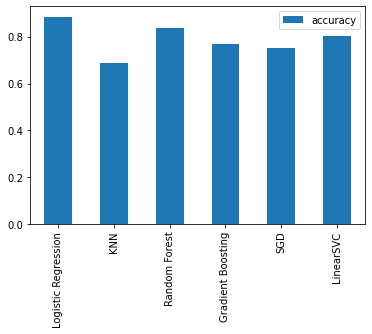

In [6]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

Upon having a baseline model, the next steps are:
* Hyperperameter tuning 
* Feature importance
* Confusion matrix
* Cross-validation
* Precision
* Recall
* F1 score
* Classification report
* ROC Curve
* Area under the curve (AUC)    

### Hyperparameter tunning

In [7]:
# KNN tune
train_scores = []
test_scores = []

# List tof values for n_neighbors
neighbors = range(1, 21)

# Setup KNN
knn = KNeighborsClassifier()

for i in neighbors:
    knn.set_params(n_neighbors=i)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

Maximum KNN score on the test data: 75.41%


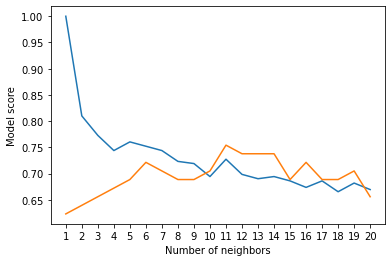

In [8]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel('Number of neighbors')
plt.ylabel('Model score')
plt.legend

print(f'Maximum KNN score on the test data: {max(test_scores)*100:.2f}%')

Because even with hyperparameter tuning the KNN model has lower accuracy score than the other models, KNN will be discarded

### Hyperparameter tunning with RandomizedSearchCV

* LogisticRegression()
* RandomForestClassifier()
* Gradient Boosting()
* LinearSVC()

In [9]:
# Create a hyperparameter for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 30),
               "solver": ["liblinear"]} 

# Create a hyperparameter for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
          "max_depth": [None, 3, 5, 10],
          "min_samples_split": np.arange(2, 20, 2),
          "min_samples_leaf": np.arange(1, 20, 2)}

# Create a hyperparameter for GradientBoosting
gb_grid = {"n_estimators": np.arange(10, 1000, 50),
          "max_depth": [None, 3, 5, 10],
          "min_samples_split": np.arange(2, 20, 2),
          "min_samples_leaf": np.arange(1, 20, 2)}

# Create a hyperparameter for LinearSVC
lsvc_grid = {"C": np.arange(1, 10, 1),
            "class_weight": ["balanced"]}

In [10]:
# Tune LogisticRegression
np.random.seed(42)

rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                               param_distributions=log_reg_grid,
                               cv=5,
                               n_iter=20,
                               verbose=True)

rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [11]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.20433597178569418}

In [12]:
# Evaluate Logistic Regression
rs_log_reg.score(X_test, y_test)

0.8852459016393442

In [13]:
np.random.seed(42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                          param_distributions=rf_grid,
                          cv=5,
                          n_iter=20,
                          verbose=True)

rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [14]:
# Check best parameters
rs_rf.best_params_

{'n_estimators': 210,
 'min_samples_split': 4,
 'min_samples_leaf': 19,
 'max_depth': 3}

In [15]:
# Evaluate Random Forest
rs_rf.score(X_test, y_test)

0.8688524590163934

In [16]:
np.random.seed(42)

rs_gb = RandomizedSearchCV(GradientBoostingClassifier(),
                          param_distributions=gb_grid,
                          cv=5,
                          n_iter=20,
                          verbose=True)

rs_gb.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [17]:
# Check best parameters
rs_gb.best_params_

{'n_estimators': 260,
 'min_samples_split': 16,
 'min_samples_leaf': 9,
 'max_depth': 10}

In [18]:
# Evaluate Gradient Boosting
rs_gb.score(X_test, y_test)

0.8360655737704918

In [19]:
np.random.seed(42)

rs_lsvc = RandomizedSearchCV(LinearSVC(),
                          param_distributions=lsvc_grid,
                          cv=5,
                          n_iter=20,
                          verbose=True)

rs_lsvc.fit(X_train, y_train)

C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinea

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, inc

RandomizedSearchCV(cv=5, estimator=LinearSVC(), n_iter=20,
                   param_distributions={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'class_weight': ['balanced']},
                   verbose=True)

In [20]:
# Check best parameters
rs_lsvc.best_params_

{'class_weight': 'balanced', 'C': 4}

In [21]:
# Evaluate Gradient Boosting
rs_lsvc.score(X_test, y_test)

0.8852459016393442

### Hyperparameter Tuning with GridSearchCV

Try GridSearhCV to enhance LogisticRegression score

In [22]:
# Create a hyperparameter for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 30),
               "solver": ["liblinear"]} # Add more hyperparameters

gs_log_reg = GridSearchCV(LogisticRegression(),
                               param_grid=log_reg_grid,
                               cv=5,
                               verbose=True)

gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [23]:
# Check best parameters
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [24]:
# Evaluate Random Forest
gs_log_reg.score(X_test, y_test)

0.8852459016393442

In [25]:
# Create a hyperparameter for LinearSVC
lsvc_grid = {"C": np.arange(1, 10, 1),
            "class_weight": ["balanced"]}

gs_lsvc = GridSearchCV(LinearSVC(),
                               param_grid=lsvc_grid,
                               cv=5,
                               verbose=True)

gs_lsvc.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, inc

C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\Pedro Alves\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, inc

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'class_weight': ['balanced']},
             verbose=True)

In [26]:
# Check best parameters
gs_lsvc.best_params_

{'C': 1, 'class_weight': 'balanced'}

In [27]:
# Evaluate Random Forest
gs_lsvc.score(X_test, y_test)

0.5573770491803278

Upon experimentation, the Logistic Regression model was selected for further experiments

## Evaluating further then accuracy

* ROC curve and AUC curve
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-score

In [28]:
# Make prediction of the model
y_preds = gs_log_reg.predict(X_test)

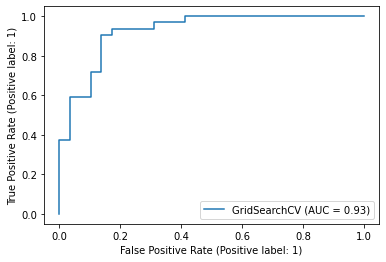

In [29]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(gs_log_reg, X_test, y_test)

In [30]:
# Confusion matrix
print(confusion_matrix(y_test, y_preds))

[[25  4]
 [ 3 29]]


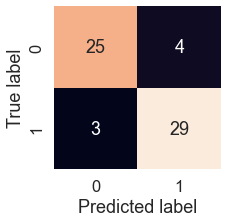

In [31]:
# Plot confusion matrix
sns.set(font_scale=1.5) # Increase font size
 
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("Predicted label") # model predictions go on the x-axis
    plt.ylabel("True label") # true labels go on the y-axis 
    
plot_conf_mat(y_test, y_preds)

In [32]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



### Calculate evaluation metrics using cross-validation

`cross_val_score()`

In [33]:
# Check best parameters
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [34]:
# Create classifier with best parameters
clf = LogisticRegression(C=gs_log_reg.best_params_['C'],
                        solver='liblinear')

In [35]:
# Function for cross-validation classification
def cv_classification(clf, X, y, metrics):
    for name, score in metrics.items():
        cv_score = cross_val_score(clf,
                            X,
                            y,
                            cv=5,
                            scoring=score)
        metrics[name] = np.mean(cv_score)
    return metrics
# print('METRIC Average cross-validated score is: ', cv_classification(clf, X, y, 'f1'))

In [36]:
metrics = {'Accuracy': 'accuracy',
           'Precision': 'precision',
           'Recall': 'recall',
           'F1': 'f1'}

In [37]:
metrics_score = cv_classification(clf=clf,
                            X=X,
                            y=y,
                            metrics=metrics)
metrics_score

{'Accuracy': 0.8446994535519124,
 'Precision': 0.8207936507936507,
 'Recall': 0.9212121212121213,
 'F1': 0.8673007976269721}

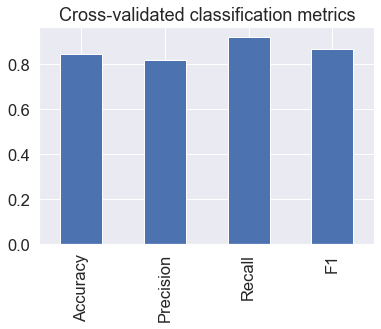

In [38]:
# Visualize cross-validated metrics
cv_metrics = pd.DataFrame(metrics_score,
                         index=[0])

cv_metrics.T.plot.bar(title='Cross-validated classification metrics',
                     legend=False);

### Feature importance

How much is a feature is important to predict a target?

In [39]:
clf = LogisticRegression(C=gs_log_reg.best_params_['C'],
                        solver='liblinear')

clf.fit(X_train, y_train);

In [40]:
# Check coef_
clf.coef_

array([[ 0.00316728, -0.86044651,  0.66067041, -0.01156993, -0.00166374,
         0.04386107,  0.31275847,  0.02459361, -0.6041308 , -0.56862804,
         0.45051628, -0.63609897, -0.67663373]])

In [41]:
# Match coef's of features to columns
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))
feature_dict

{'age': 0.0031672801993431563,
 'sex': -0.8604465072345515,
 'cp': 0.6606704082033799,
 'trestbps': -0.01156993168080875,
 'chol': -0.001663744504776871,
 'fbs': 0.043861071652469864,
 'restecg': 0.31275846822418324,
 'thalach': 0.024593613737779126,
 'exang': -0.6041308000615746,
 'oldpeak': -0.5686280368396555,
 'slope': 0.4505162797258308,
 'ca': -0.6360989676086223,
 'thal': -0.6766337263029825}

<AxesSubplot:title={'center':'Feature Importance'}>

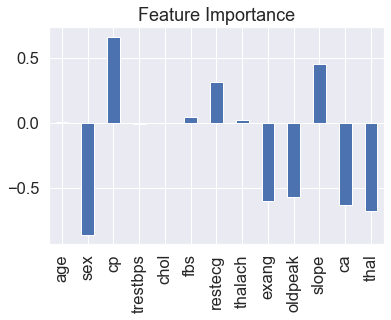

In [42]:
# Visualize feature of importance
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title='Feature Importance', legend=False)